___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://glasswing.vc/wp-content/uploads/2023/10/16-CNNs.webp" width="350px" height="180px" />


# <font color= #8A0829> Laboratorio de Modelado de Datos </font>
#### <font color= #2E9AFE> `Martes y Viernes (Videoconferencia) de 13:00 - 15:00 hrs`</font>
- <Strong> Sara Eugenia Rodríguez </Strong>
- <Strong> Año </Strong>: 2025
- <Strong> Email: </Strong>  <font color="blue"> `sara.rodriguezr@iteso.mx` </font>
___

<p style="text-align:right;"> Imagen recuperada de: https://glasswing.vc/wp-content/uploads/2023/10/16-CNNs.webp</p>

### <font color= #2E9AFE> Tema: Entrenando un clasificador CNN</font>


**MLP**

Funcionan mejor para:
- Datos tabulares (columnas de características)
- Pequeños conjuntos de datos donde la estructura espacial es irrelevante
- Tareas simples de clasificación o regresión PERO que los datos sean de alta dimensión o que haya relaciones no lineales complejas

No son buenas para:
- Imágenes
- Video
- Audio
- Cualquier cosa con estructuras espaciales

**CNN**

Diseñadas específicamente para imágenes o cualquier cosa que tenga patrones espaciales locales.

Funcionan mejor para:
- Clasificacion de imágenes
- Detección de objetos
- Video

Las CNN parten de tres supuestos:
1. Existe estructura espacial

Una CNN espera que los datos tengan forma (altura, largo, ancho) pero en un dataset tabular como: edad, ingresos, historial crediticio, ciudad. No existe ninguna estructura espacial. No tiene sentido aplicar un filtro 3x3 sobre [Edad, Ingresos, Ciudad]

2. Esperan traslación invariance

Una CNN aprende que un borde sigue siendo un borde, esté donde esté la imagen. Pero en los datos tabulares:
- que "edad" esté en la columna 0 y "ingresos" en columna 1 NO significa que moverlos de sitio conserve el significado. 

No son buenas para:
- Datos tabulares


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple as nt
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.datasets import cifar10

#Creamos un objeto con sus atributos
Data = nt("Data", "x_train y_train x_valid y_valid x_test y_test")

In [2]:
# Cargamos los datos
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
data = Data(x_train, y_train, None, None, x_test, y_test)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 47s 0us/step


In [3]:
cifar10_labels = [
    "airplane", 
    "automobile", 
    "bird", 
    "cat", 
    "deer", 
    "dog", 
    "frog", 
    "horse", 
    "ship", 
    "truck"
]

In [4]:
def visualize_data(data):
    images_to_show = 36
    per_row = 12
    fig = plt.figure(figsize=(20,5))
    for i in range(images_to_show):
        pos = (i // per_row, ((i % per_row) + per_row) % per_row)
        ax = plt.subplot2grid((int(images_to_show / per_row), per_row),
                              pos, xticks=[], yticks=[])
        ax.imshow(np.squeeze(data.x_train[i]))
    plt.show()

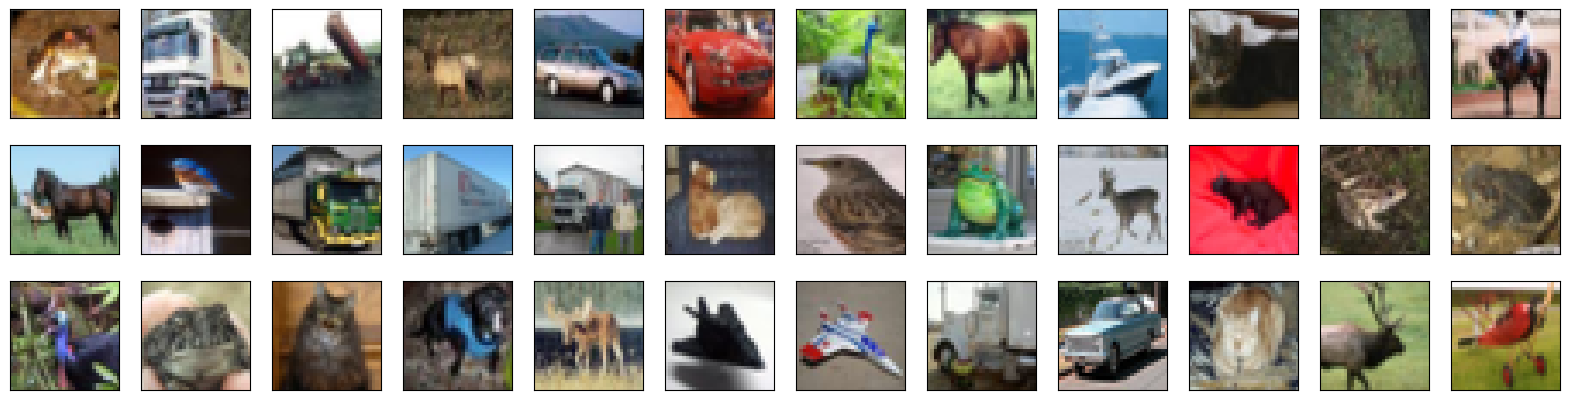

In [5]:
# Visualizamos los datos
visualize_data(data)

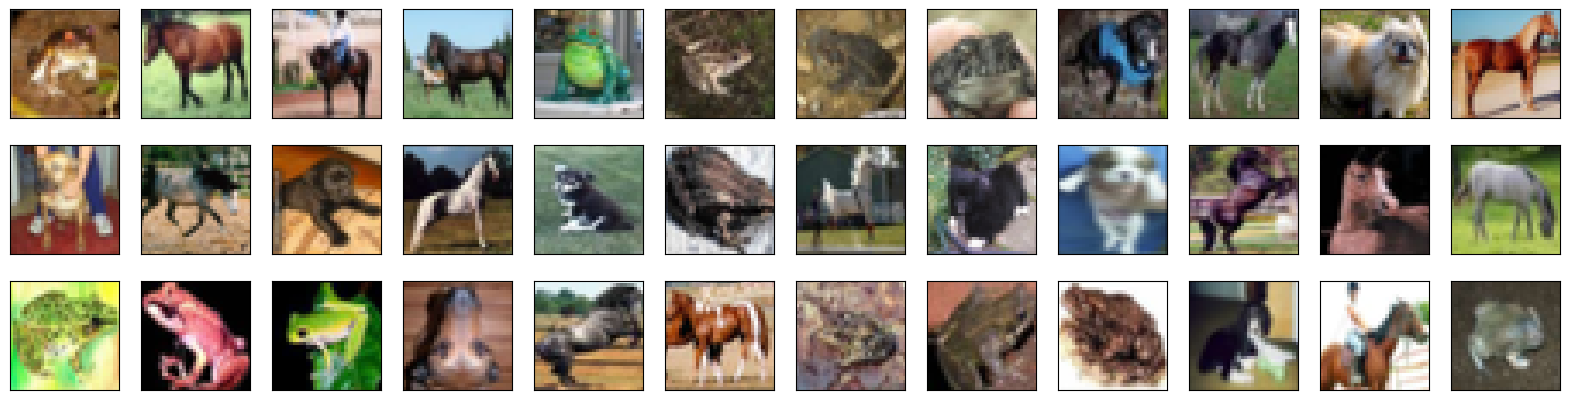

In [6]:
#Vamos a trabjar solo con imagenes de Perros, Ranas y Caballos para que la carga computacional sea menor
selected_classes = [5, 6, 7]

train_mask = np.isin(y_train, selected_classes).flatten()
x_train_filtered = x_train[train_mask]
y_train_filtered = y_train[train_mask]

test_mask = np.isin(y_test, selected_classes).flatten()
x_test_filtered = x_test[test_mask]
y_test_filtered = y_test[test_mask]

filtered_data = Data(
    x_train_filtered,
    y_train_filtered,
    None, None,
    x_test_filtered,
    y_test_filtered
)

visualize_data(filtered_data)

In [7]:
#Están balanceadas nuestras clases?
classes, counts = np.unique(filtered_data.y_train, return_counts=True)
print(list(zip(classes, counts)))

[(np.uint8(5), np.int64(5000)), (np.uint8(6), np.int64(5000)), (np.uint8(7), np.int64(5000))]


In [8]:
# Curva de aprendizaje
def visualize_training(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.show()
    
    # training vs validation loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

**Preprocesamiento**

Las imagenes son de 32x32 pixeles con valores entre 0 y 255 por cada pixel. 
Al hacerse demasiadas multiplicaciones vamos a dividir nuestros valores entre 255 de forma que los calculos no exploten en cada iteracion. 

RGB significa:
- R = Red (Rojo)
- G = Green (Verde)
- B = Blue (Azul)

Por ejemplo un pixel:
[255, 0, 0] → rojo puro  
[0, 255, 0] → verde puro  
[0, 0, 255] → azul puro  
[255, 255, 255] → blanco  
[0, 0, 0] → negro

Entonces un pixel puede tener 256 × 256 × 256 ≈ 16 millones de colores, por eso los modelos de deep learning normalizan los valores de 0 a 1. 


De la libreria de Keras vamos a usar la funcion "to_categorical" para hacer el one hot encoding a nuestras etiquetas. 

Vamos a seleccionar las primeras 5000 imagenes como train y las siguientes 5000 como validation

Vamos a usar un set de validation para medir el accuracy durante el entrenamiento de la red yvamos a usar los datos del test para correr toda la red contra datos que no se han visto


In [9]:

def preprocess(data, categories):
    x_train = data.x_train.astype("float32") / 255
    x_test = data.x_test.astype("float32") / 255
    y_train = to_categorical(data.y_train, categories)
    y_test = to_categorical(data.y_test, categories)    
    return Data(x_train[5000:], y_train[5000:],
                x_train[:5000], y_train[:5000],
                x_test, y_test)

In [10]:
# Procesamos los datos
label_map = {5: 0, 6: 1, 7: 2}

y_train_mapped = np.vectorize(label_map.get)(filtered_data.y_train)
y_test_mapped  = np.vectorize(label_map.get)(filtered_data.y_test)

filtered_data = Data(
    filtered_data.x_train,
    y_train_mapped,
    filtered_data.x_valid,
    filtered_data.y_valid,
    filtered_data.x_test,
    y_test_mapped
)

categories = len(np.unique(y_train_mapped))
print("Shape de x_train pre-processing: ", filtered_data.x_train.shape)
print("Shape de y_train pre-processing: ", filtered_data.y_train.shape)
processed_data = preprocess(filtered_data, categories)
print("Shape de x_train post-processing: ", processed_data.x_train.shape)
print("Shape de y_train post-processing: ", processed_data.y_train.shape)

Shape de x_train pre-processing:  (15000, 32, 32, 3)
Shape de y_train pre-processing:  (15000, 1)
Shape de x_train post-processing:  (10000, 32, 32, 3)
Shape de y_train post-processing:  (10000, 3)


## MLP


In [11]:
def build_mlp(data, categories):
    model = Sequential()
    #En CIFAR una imagen tiene forma 32x32x3 --> 3072 valores, la mlp solo puede procesar vectores
    model.add(Flatten(input_shape=data.x_train.shape[1:]))
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(categories, activation="softmax"))
    
    # Compilamos el modelo
    model.compile(loss="categorical_crossentropy", optimizer="adam", 
                  metrics=["accuracy"])
    return model

In [12]:
# Build mlp
mlp = build_mlp(processed_data, categories)
print("Arquitectura de la MLP:")
mlp.summary()

c:\Users\oweno\anaconda3.1\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Arquitectura de la MLP:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │     3,073,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,587,051 (13.68 MB)

 Trainable params: 3,587,051 (13.68 MB)

 Non-trainable params: 0 (0.00 B)

Son muchisimos parametros!

In [13]:
#Entrenamos el mlp
hist_mlp = mlp.fit(processed_data.x_train, processed_data.y_train, batch_size=32, 
                   epochs=20, validation_data=(processed_data.x_valid,
                                                processed_data.y_valid),
                    shuffle=True)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.5088 - loss: 1.0672 - val_accuracy: 0.6156 - val_loss: 0.8674
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5750 - loss: 0.9064 - val_accuracy: 0.6406 - val_loss: 0.8351
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.6019 - loss: 0.8633 - val_accuracy: 0.6402 - val_loss: 0.8378
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.6231 - loss: 0.8303 - val_accuracy: 0.6438 - val_loss: 0.8118
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.6210 - loss: 0.8290 - val_accuracy: 0.6566 - val_loss: 0.7870
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.6157 - loss: 0.8397 - val_accuracy: 0.6572 - val_loss: 0.7881
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.6269 - loss: 0.8191 - val_accuracy: 0.6650 - val_loss: 0.7733
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.6521 - loss: 0.7850 - 

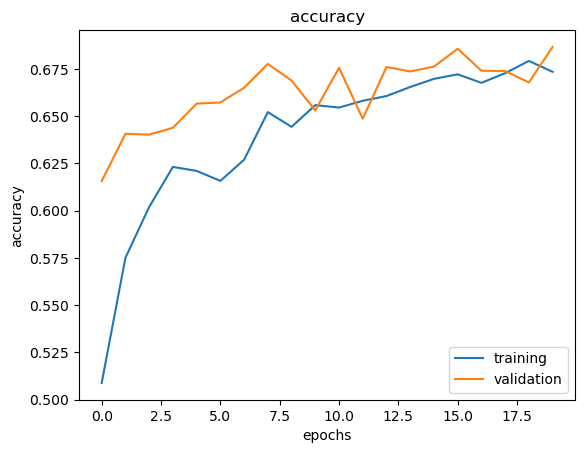

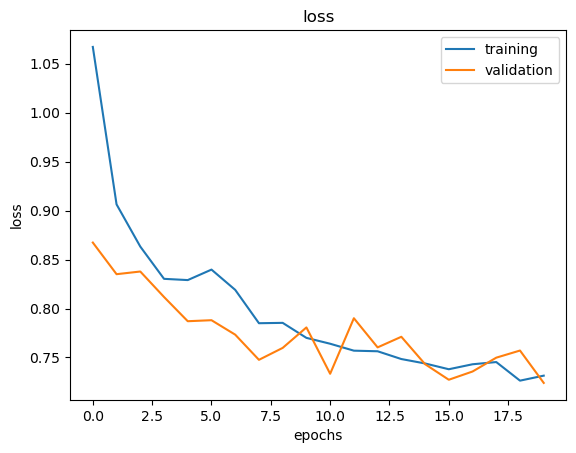

In [14]:
visualize_training(hist_mlp)

## CNN

In [15]:
from keras.layers import Conv2D, MaxPooling2D

In [16]:
def build_cnn(data, categories):
    model = Sequential()
    #algo comun que se hace es duplicar los fitlros en cada bloque
    #padding = same hace que las dimensiones de las imagenes permanezcan controladas
    model.add(Conv2D(filters=16, kernel_size=2, padding="same", activation="relu",
                     input_shape=data.x_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(500, activation="relu"))
    model.add(Dropout(0.4))
    model.add(Dense(categories, activation="softmax"))
    
    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy"])
    return model

In [17]:
cnn = build_cnn(processed_data, categories)
print("CNN architecture:")
cnn.summary()

c:\Users\oweno\anaconda3.1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 500)            │       512,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │         1,503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,547 (2.00 MB)

 Trainable params: 524,547 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the cnn
hist_cnn = cnn.fit(processed_data.x_train, processed_data.y_train, batch_size=32, 
                   epochs=20, validation_data=(processed_data.x_valid, 
                                               processed_data.y_valid))

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6343 - loss: 0.8085 - val_accuracy: 0.7382 - val_loss: 0.6151
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7420 - loss: 0.6119 - val_accuracy: 0.7782 - val_loss: 0.5303
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7739 - loss: 0.5453 - val_accuracy: 0.8104 - val_loss: 0.4684
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8057 - loss: 0.4753 - val_accuracy: 0.8174 - val_loss: 0.4447
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8221 - loss: 0.4373 - val_accuracy: 0.8038 - val_loss: 0.4876
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8368 - loss: 0.4074 - val_accuracy: 0.8420 - val_loss: 0.3927
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.8542 - loss: 0.3718 - val_accuracy: 0.8484 - val_loss: 0.3838
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8564 - loss: 0.3633 - val_

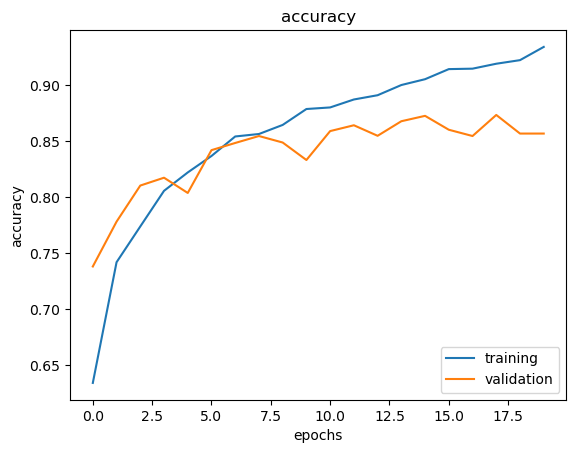

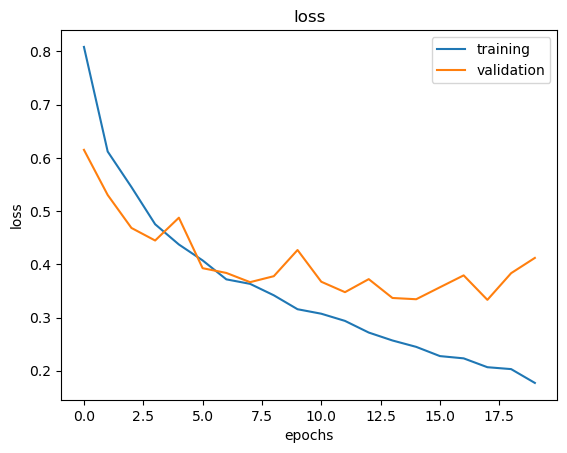

In [19]:
visualize_training(hist_cnn)

In [20]:
# Comparamos los scores
score_mlp = mlp.evaluate(processed_data.x_test, processed_data.y_test, verbose=0)
score_cnn = cnn.evaluate(processed_data.x_test, processed_data.y_test, verbose=0)

print("Accuracy mlp: {0:.2f}%".format(score_mlp[1] * 100))
print("Accuracy cnn: {0:.2f}%".format(score_cnn[1] * 100))

Accuracy mlp: 69.10%
Accuracy cnn: 85.83%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


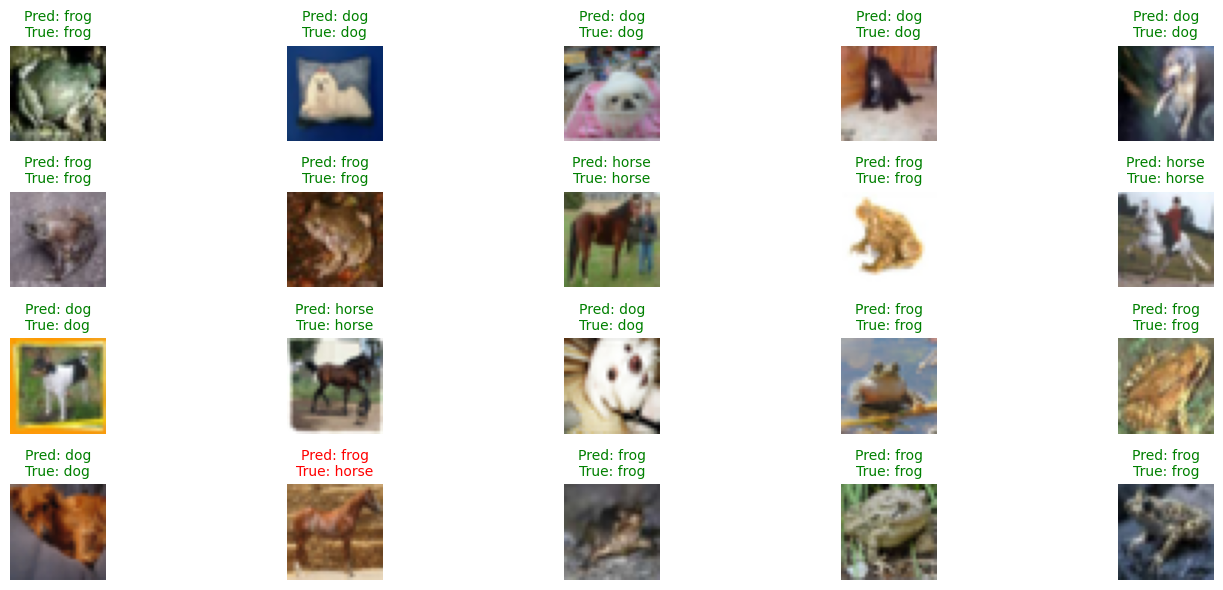

In [21]:
class_names = {0: "dog", 1: "frog", 2: "horse"}
def visualize_predictions(model, data, class_names, num_images=20):
    # Seleccionamos un subset aleatorio
    idxs = np.random.choice(len(data.x_test), num_images, replace=False)
    images = data.x_test[idxs]
    true_labels = np.argmax(data.y_test[idxs], axis=1)

    # Predicciones
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(idxs):
        plt.subplot(4, 5, i+1)
        plt.imshow(images[i])
        plt.axis("off")

        true_c = true_labels[i]
        pred_c = pred_labels[i]

        # Color del texto
        color = "green" if true_c == pred_c else "red"

        plt.title(
            f"Pred: {class_names[pred_c]}\nTrue: {class_names[true_c]}",
            color=color,
            fontsize=10
        )

    plt.tight_layout()
    plt.show()

visualize_predictions(cnn, processed_data, class_names, num_images=20)